In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mceq_config as config
from MCEq.core import MCEqRun
import crflux.models as pm
from MCEq.data import InteractionCrossSections
from scipy.interpolate import CubicSpline
from utils.helpers import *

In [ ]:
class ModIntCrossSections(InteractionCrossSections):
    def __init__(self, mceq_hdf_db, interaction_model="SIBYLL2.3c", scale_factor=None,threshold =1., increase = 'const'): # first pion then kaon, incrase = const or exp
        self.scale_factor = scale_factor  # Default scaling factor
        self.threshold = threshold
        self.increase = increase
        self.interaction_model = interaction_model
        super().__init__(mceq_hdf_db, interaction_model)  # Call parent constructor

    def modify_cs(self, scale_factor=None,threshold =None, increase = None):
        """ Kaon Pion modification abovethreshold - exp or const increase """
        if scale_factor is None:
            scale_factor = self.scale_factor  # Use the default if not specified
        if threshold is None:
            threshold = self.threshold

        e_range = self.energy_grid.c > threshold
        e0 = self.energy_grid.c[e_range][0]
        print(f"Applying mod with scaling factor: {scale_factor}, threshold e0: {e0}")

        if self.increase == 'exp':
            for p, sf in zip([211, 321], scale_factor):    # Loop over particle types # modify pions
                self.index_d[p][e_range] *= (self.energy_grid.c[e_range] / e0) ** sf

        elif self.increase == 'const':
            for p, sf in zip([211, 321], scale_factor):    
                self.index_d[p][e_range] *= (sf)

    def load(self, interaction_model):
        """ Load the interaction model and apply the modification function """
        super().load(interaction_model)
        self.modify_cs()


In [ ]:
#the ony working example :(

class ModIntCrossSections(InteractionCrossSections):
    def __init__(self, mceq_hdf_db, interaction_model="SIBYLL2.3c", scale_factor_region1=None, scale_factor_region2=None, e0=1., e1=None, increase='const'):
        self.scale_factor_region1 = scale_factor_region1  # Scaling factor for e0 to e1
        self.scale_factor_region2 = scale_factor_region2  # Scaling factor for > e1
        self.e0 = e0
        self.e1 = e1
        self.increase = increase
        self.interaction_model = interaction_model
        super().__init__(mceq_hdf_db, interaction_model)  # Call parent constructor

    def modify_cs(self, scale_factor_region1=None, scale_factor_region2=None, e0=None, e1=None, increase=None):
        """Modify pion and kaon interaction cross-sections in two energy regions."""
        
        # Set defaults
        if scale_factor_region1 is None:
            scale_factor_region1 = self.scale_factor_region1
        if scale_factor_region2 is None:
            scale_factor_region2 = self.scale_factor_region2
        if e0 is None:
            e0 = self.e0
        if e1 is None:
            e1 = self.e1  # e1 might still be None here

        # Energy ranges
        e_range1 = (self.energy_grid.c > e0)
        if e1 is not None:  
            e_range1 &= (self.energy_grid.c < e1)
            
            # Find the index at e1 and start the second region from the second bin after e1
            idx_at_e1 = np.searchsorted(self.energy_grid.c, e1)
            e_range2 = self.energy_grid.c >= self.energy_grid.c[idx_at_e1 + 1]  # Start from the second bin after e1
        else:
            e_range2 = np.zeros_like(self.energy_grid.c, dtype=bool)

        print(f"Applying mod: region1 ({e0}-{e1}) with {scale_factor_region1}, region2 (> {e1}) with {scale_factor_region2}")

        # Apply scaling factors first for the energy range before e1 (excluding idx_at_e1)
        if self.increase == 'exp':
            for p, sf1, sf2 in zip([211, 321], scale_factor_region1, scale_factor_region2):
                self.index_d[p][e_range1] *= (self.energy_grid.c[e_range1] / e0) ** sf1
        elif self.increase == 'const':
            for p, sf1, sf2 in zip([211, 321], scale_factor_region1, scale_factor_region2):
                self.index_d[p][e_range1] *= sf1

        print(self.energy_grid.c[idx_at_e1])

        # Now handle smooth transitions for e1 if necessary
        if e1 is not None:
            self.smooth_transition(e0, e1)

    def smooth_transition(self, e0, e1):
        """Smooth transition for values around e1 using interpolation."""
        
        if e0 is None or e1 is None:
            raise ValueError("e0 and e1 must be specified.")
        
        # Find the index at e1
        idx_at_e1 = np.searchsorted(self.energy_grid.c, e1)

        # The index at e1 will be the first position where the energy is greater than or equal to e1
        energy_at_e1 = self.energy_grid.c[idx_at_e1] if idx_at_e1 < len(self.energy_grid.c) else None
        
        # Ensure e1 is within the energy grid
        if energy_at_e1 is None or energy_at_e1 > self.energy_grid.c[-1]:
            print(f"Warning: e1 = {e1} is outside the energy grid, using the last energy grid value instead.")
            energy_at_e1 = self.energy_grid.c[-1]  # Set to last value if out of bounds
        
        # Interpolation of scaling factors between energy bins around e1
        for p, sf1, sf2 in zip([211, 321], self.scale_factor_region1, self.scale_factor_region2):
            if self.increase == 'exp':
                # Avoid modifying idx_at_e1 or bins after it in this loop
                if e1 is not None:
                    self.index_d[p][(idx_at_e1+1):] = self.index_d[p][(idx_at_e1+1):] * (self.energy_grid.c[idx_at_e1:] / e0) ** sf2
            elif self.increase == 'const':
                self.index_d[p][(idx_at_e1+1):] *= sf2  # Scale for region2 from e1 +1 onward

            # Interpolation using cubic spline for smooth transition
            cs = CubicSpline([self.energy_grid.c[idx_at_e1 - 1], self.energy_grid.c[idx_at_e1 + 1]], [sf1, sf2], bc_type='natural')
            interpolated_value = cs(energy_at_e1)
            self.index_d[p][idx_at_e1] *= interpolated_value

            # Optional: Plot for visual check of the interpolation
            plt.figure(figsize=(6, 4))
            plt.plot([self.energy_grid.c[idx_at_e1 - 1], self.energy_grid.c[idx_at_e1 + 1]], [sf1, sf2], 'ro', label="Original Points")
            plt.plot(energy_at_e1, interpolated_value, 'bo', label="Interpolated Point at e1")
            plt.xscale("log")
            plt.xlabel("Energy [GeV]")
            plt.ylabel("Scaling Factor")
            plt.legend()
            plt.grid()
            plt.show()

    def load(self, interaction_model):
        """Load the interaction model and apply the modification function."""
        super().load(interaction_model)
        self.modify_cs()


In [40]:
#modifz the only working example

class ModIntCrossSections(InteractionCrossSections):
    def __init__(self, mceq_hdf_db, interaction_model="SIBYLL2.3c", scale_factor_region1=None, scale_factor_region2=None, e0=1., e1=None, increase='const'):
        self.scale_factor_region1 = scale_factor_region1  # Scaling factor for e0 to e1
        self.scale_factor_region2 = scale_factor_region2  # Scaling factor for > e1
        self.e0 = e0
        self.e1 = e1
        self.increase = increase
        self.interaction_model = interaction_model
        super().__init__(mceq_hdf_db, interaction_model)  # Call parent constructor

    def modify_cs(self, scale_factor_region1=None, scale_factor_region2=None, e0=None, e1=None, increase=None):
        """Modify pion and kaon interaction cross-sections in two energy regions."""
        
        # Set defaults
        if scale_factor_region1 is None:
            scale_factor_region1 = self.scale_factor_region1
        if scale_factor_region2 is None:
            scale_factor_region2 = self.scale_factor_region2
        if e0 is None:
            e0 = self.e0
        if e1 is None:
            e1 = self.e1  # e1 might still be None here

        # Energy ranges
        e_range1 = (self.energy_grid.c > e0)
        if e1 is not None:  
            e_range1 &= (self.energy_grid.c < e1)

            # Find the index at e1 and start the second region from the second bin after e1
            idx_at_e0 = np.searchsorted(self.energy_grid.c, e0)
            e_range1 = self.energy_grid.c >= self.energy_grid.c[idx_at_e0 + 1]
            
            # Find the index at e1 and start the second region from the second bin after e1
            idx_at_e1 = np.searchsorted(self.energy_grid.c, e1)
            e_range1 &= self.energy_grid.c <= self.energy_grid.c[idx_at_e1 - 1]  # set upper bound region 1

            e_range2 = self.energy_grid.c >= self.energy_grid.c[idx_at_e1 + 1]  # Start from the second bin after e1
        else:
            e_range2 = np.zeros_like(self.energy_grid.c, dtype=bool)

        print(f"Applying mod: region1 ({e0}-{e1}) with {scale_factor_region1}, region2 (> {e1}) with {scale_factor_region2}")

        # Apply scaling factors first for the energy range before e1 (excluding idx_at_e1)
        if self.increase == 'exp':
            for p, sf1, sf2 in zip([211, 321], scale_factor_region1, scale_factor_region2):
                self.index_d[p][e_range1] *= (self.energy_grid.c[e_range1] / e0) ** sf1
        elif self.increase == 'const':
            for p, sf1, sf2 in zip([211, 321], scale_factor_region1, scale_factor_region2):
                self.index_d[p][e_range1] *= sf1

       
        # Now handle smooth transitions for e0 and e1 if necessary
        if e1 is not None:
            self.smooth_transition(e0, e1)

    def smooth_transition(self, e0, e1):
        """Smooth transition for values around e1 using interpolation."""
        
        if e0 is None or e1 is None:
            raise ValueError("e0 and e1 must be specified.")
        
        # Find the index at e1 and e0
        idx_at_e0 = np.searchsorted(self.energy_grid.c, e0)
        idx_at_e1 = np.searchsorted(self.energy_grid.c, e1)

        # The index at e1 will be the first position where the energy is greater than or equal to e1
        energy_at_e0 = self.energy_grid.c[idx_at_e0] if idx_at_e0 < len(self.energy_grid.c) else None
        energy_at_e1 = self.energy_grid.c[idx_at_e1] if idx_at_e1 < len(self.energy_grid.c) else None
        
        # Ensure e1 is within the energy grid
        if energy_at_e0 is None or energy_at_e0 > self.energy_grid.c[-1]:
            print(f"Warning: e1 = {e1} is outside the energy grid, using the last energy grid value instead.")
            energy_at_e0 = self.energy_grid.c[-1]  # Set to last value if out of bounds

        if energy_at_e1 is None or energy_at_e1 > self.energy_grid.c[-1]:
            print(f"Warning: e1 = {e1} is outside the energy grid, using the last energy grid value instead.")
            energy_at_e1 = self.energy_grid.c[-1]  # Set to last value if out of bounds
        
        # Interpolation of scaling factors between energy bins around e1
        for p, sf1, sf2 in zip([211, 321], self.scale_factor_region1, self.scale_factor_region2):
            if self.increase == 'exp':
                # Avoid modifying idx_at_e1 or bins after it in this loop
                if e1 is not None:
                    self.index_d[p][(idx_at_e1+1):] = self.index_d[p][(idx_at_e1+1):] * (self.energy_grid.c[idx_at_e1:] / e0) ** sf2
            elif self.increase == 'const':
                self.index_d[p][(idx_at_e1+1):] *= sf2  # Scale for region2 from e1 +1 onward

            # Interpolation using cubic spline for smooth transition
            cs_e1 = CubicSpline([self.energy_grid.c[idx_at_e1 - 1], self.energy_grid.c[idx_at_e1 + 1]], [sf1, sf2], bc_type='natural')
            interpolated_value_e1 = cs_e1(energy_at_e1)
            self.index_d[p][idx_at_e1] *= interpolated_value_e1

            # Interpolation using cubic spline for smooth transition
            cs_e0 = CubicSpline([self.energy_grid.c[idx_at_e0 - 1], self.energy_grid.c[idx_at_e0 + 1]], [1., sf1], bc_type='natural')
            interpolated_value_e0 = cs_e0(energy_at_e0)
            self.index_d[p][idx_at_e0] *= interpolated_value_e0

            # Optional: Plot for visual check of the interpolation
            plt.figure(figsize=(6, 4))
            plt.plot([self.energy_grid.c[idx_at_e0 - 1], self.energy_grid.c[idx_at_e0 + 1]], [1., sf1], 'ro', label="Original Points")
            plt.plot(energy_at_e0, interpolated_value_e0, 'bo', label="Interpolated Point at e0")
            plt.plot(np.linspace(800,1500,50),cs_e0(np.linspace(800,1500,50)),label='interpolation')
            plt.xscale("log")
            plt.xlabel("Energy [GeV]")
            plt.ylabel("Scaling Factor")
            plt.legend()
            plt.grid()
            plt.show()

            # Optional: Plot for visual check of the interpolation
            plt.figure(figsize=(6, 4))
            plt.plot([self.energy_grid.c[idx_at_e1 - 1], self.energy_grid.c[idx_at_e1 + 1]], [sf1, sf2], 'ro', label="Original Points")
            plt.plot(np.linspace(8000,15000,50),cs_e0(np.linspace(8000,15000,50)),label='interpolation')
            plt.plot(energy_at_e1, interpolated_value_e1, 'bo', label="Interpolated Point at e1")
            plt.xscale("log")
            plt.xlabel("Energy [GeV]")
            plt.ylabel("Scaling Factor")
            plt.legend()
            plt.grid()
            plt.show()

    def load(self, interaction_model):
        """Load the interaction model and apply the modification function."""
        super().load(interaction_model)
        self.modify_cs()


In [ ]:
# test longer interpolation range
class ModIntCrossSections(InteractionCrossSections):
    def __init__(self, mceq_hdf_db, interaction_model="SIBYLL2.3c", scale_factor_region1=None, scale_factor_region2=None, e0=1., e1=None, increase='const'):
        self.scale_factor_region1 = scale_factor_region1  # Scaling factor for e0 to e1
        self.scale_factor_region2 = scale_factor_region2  # Scaling factor for > e1
        self.e0 = e0
        self.e1 = e1
        self.increase = increase
        self.interaction_model = interaction_model
        super().__init__(mceq_hdf_db, interaction_model)  # Call parent constructor

    def modify_cs(self, scale_factor_region1=None, scale_factor_region2=None, e0=None, e1=None, increase=None):
        """Modify pion and kaon interaction cross-sections in two energy regions."""
        
        # Set defaults
        if scale_factor_region1 is None:
            scale_factor_region1 = self.scale_factor_region1
        if scale_factor_region2 is None:
            scale_factor_region2 = self.scale_factor_region2
        if e0 is None:
            e0 = self.e0
        if e1 is None:
            e1 = self.e1  # e1 might still be None here

        # Energy ranges
        e_range1 = (self.energy_grid.c > e0)
        if e1 is not None:  
            e_range1 &= (self.energy_grid.c < e1)

            # Find the index at e1 and start the second region from the second bin after e1
            idx_at_e0 = np.searchsorted(self.energy_grid.c, e0)
            e_range1 = self.energy_grid.c >= self.energy_grid.c[idx_at_e0 + 1]
            
            # Find the index at e1 and start the second region from the second bin after e1
            idx_at_e1 = np.searchsorted(self.energy_grid.c, e1)
            e_range1 &= self.energy_grid.c <= self.energy_grid.c[idx_at_e1 - 1]  # set upper bound region 1

            e_range2 = self.energy_grid.c >= self.energy_grid.c[idx_at_e1 + 1]  # Start from the second bin after e1
        else:
            e_range2 = np.zeros_like(self.energy_grid.c, dtype=bool)

        print(f"Applying mod: region1 ({e0}-{e1}) with {scale_factor_region1}, region2 (> {e1}) with {scale_factor_region2}")

        # Apply scaling factors first for the energy range before e1 (excluding idx_at_e1)
        if self.increase == 'exp':
            for p, sf1, sf2 in zip([211, 321], scale_factor_region1, scale_factor_region2):
                self.index_d[p][e_range1] *= (self.energy_grid.c[e_range1] / e0) ** sf1
        elif self.increase == 'const':
            for p, sf1, sf2 in zip([211, 321], scale_factor_region1, scale_factor_region2):
                self.index_d[p][e_range1] *= sf1

       
        # Now handle smooth transitions for e0 and e1 if necessary
        if e1 is not None:
            self.smooth_transition(e0, e1)

    def smooth_transition(self, e0, e1):
        """Smooth transition for values around e1 using interpolation."""
        
        if e0 is None or e1 is None:
            raise ValueError("e0 and e1 must be specified.")
        
        # Energy ranges
        e_range1 = (self.energy_grid.c > e0)
        if e1 is not None:  
            e_range1 &= (self.energy_grid.c < e1)

            # Find the index at e1 and start the second region from the second bin after e1
            idx_at_e0 = np.searchsorted(self.energy_grid.c, e0)
            e_range1 = self.energy_grid.c >= self.energy_grid.c[idx_at_e0 + 1]
            
            # Find the index at e1 and start the second region from the second bin after e1
            idx_at_e1 = np.searchsorted(self.energy_grid.c, e1)
            e_range1 &= self.energy_grid.c <= self.energy_grid.c[idx_at_e1 - 1]  # set upper bound region 1

            e_range2 = self.energy_grid.c >= self.energy_grid.c[idx_at_e1 + 1]  # Start from the second bin after e1
        else:
            e_range2 = np.zeros_like(self.energy_grid.c, dtype=bool)
        
        # Find the index at e1 and e0
        idx_at_e0 = np.searchsorted(self.energy_grid.c, e0)
        idx_at_e1 = np.searchsorted(self.energy_grid.c, e1)

        # The index at e1 will be the first position where the energy is greater than or equal to e1
        energy_at_e0 = self.energy_grid.c[idx_at_e0] if idx_at_e0 < len(self.energy_grid.c) else None
        energy_at_e1 = self.energy_grid.c[idx_at_e1] if idx_at_e1 < len(self.energy_grid.c) else None
        
        # Ensure e1 is within the energy grid
        if energy_at_e0 is None or energy_at_e0 > self.energy_grid.c[-1]:
            print(f"Warning: e1 = {e1} is outside the energy grid, using the last energy grid value instead.")
            energy_at_e0 = self.energy_grid.c[-1]  # Set to last value if out of bounds

        if energy_at_e1 is None or energy_at_e1 > self.energy_grid.c[-1]:
            print(f"Warning: e1 = {e1} is outside the energy grid, using the last energy grid value instead.")
            energy_at_e1 = self.energy_grid.c[-1]  # Set to last value if out of bounds
        
        # Interpolation of scaling factors between energy bins around e1
        for p, sf1, sf2 in zip([211, 321], self.scale_factor_region1, self.scale_factor_region2):
            if self.increase == 'exp':
                # Avoid modifying idx_at_e1 or bins after it in this loop
                if e1 is not None:
                    self.index_d[p][(idx_at_e1+1):] = self.index_d[p][(idx_at_e1+1):] * (self.energy_grid.c[idx_at_e1:] / e0) ** sf2
            elif self.increase == 'const':
                self.index_d[p][(idx_at_e1+1):] *= sf2  # Scale for region2 from e1 +1 onward

            # Interpolation using cubic spline for smooth transition
            print(len(self.energy_grid.c[e_range1] + [self.energy_grid.c[idx_at_e1 + 1]])) # this is the thing that needs to be solved
            print(np.append(np.ones(len(e_range1)), sf2))
            cs_e1 = CubicSpline(self.energy_grid.c[e_range1] + [self.energy_grid.c[idx_at_e1 + 1]], np.append(np.ones(len(e_range1)), sf2), bc_type='natural') # adjust this line
            interpolated_value_e1 = cs_e1(energy_at_e1)
            self.index_d[p][idx_at_e1] *= interpolated_value_e1

            # Interpolation using cubic spline for smooth transition
            cs_e0 = CubicSpline([self.energy_grid.c[idx_at_e0 - 1], self.energy_grid.c[idx_at_e0 + 1]], [1., sf1], bc_type='natural')
            interpolated_value_e0 = cs_e0(energy_at_e0)
            self.index_d[p][idx_at_e0] *= interpolated_value_e0

            # Optional: Plot for visual check of the interpolation
            plt.figure(figsize=(6, 4))
            plt.plot([self.energy_grid.c[idx_at_e0 - 1], self.energy_grid.c[idx_at_e0 + 1]], [1., sf1], 'ro', label="Original Points")
            plt.plot(energy_at_e0, interpolated_value_e0, 'bo', label="Interpolated Point at e0")
            plt.plot(np.linspace(800,1500,50),cs_e0(np.linspace(800,1500,50)),label='interpolation')
            plt.xscale("log")
            plt.xlabel("Energy [GeV]")
            plt.ylabel("Scaling Factor")
            plt.legend()
            plt.grid()
            plt.show()

            # Optional: Plot for visual check of the interpolation
            plt.figure(figsize=(6, 4))
            plt.plot([self.energy_grid.c[idx_at_e1 - 1], self.energy_grid.c[idx_at_e1 + 1]], [sf1, sf2], 'ro', label="Original Points")
            plt.plot(np.linspace(8000,15000,50),cs_e0(np.linspace(8000,15000,50)),label='interpolation')
            plt.plot(energy_at_e1, interpolated_value_e1, 'bo', label="Interpolated Point at e1")
            plt.xscale("log")
            plt.xlabel("Energy [GeV]")
            plt.ylabel("Scaling Factor")
            plt.legend()
            plt.grid()
            plt.show()

    def load(self, interaction_model):
        """Load the interaction model and apply the modification function."""
        super().load(interaction_model)
        self.modify_cs()


In [57]:
# test if interpoaltion works

interactionmodel = 'SIBYLL23C'
increase = 'const'
e0 = 1.e3
e1 = 1.e4
scale_factor_region1 = [1.05,1.]
scale_factor_region2 = [1.1,1.]

#initialize mceq instances
mceq_tune = MCEqRun(
        interaction_model=interactionmodel,
        theta_deg=0.0,
        primary_model=(pm.HillasGaisser2012, "H3a"),
        density_model = (('MSIS00_IC',('SouthPole','January')))
    )

mceq= MCEqRun(
    interaction_model=interactionmodel,
    theta_deg=0.0,
    primary_model=(pm.HillasGaisser2012, "H3a"),
    density_model = (('MSIS00_IC',('SouthPole','January')))
)

# modify cross section
modcs = ModIntCrossSections(mceq._mceq_db, interaction_model="SIBYLL2.3c", scale_factor_region1=scale_factor_region1, scale_factor_region2=scale_factor_region2, e0=e0, e1=e1, increase='const') 

mceq_tune._int_cs = modcs # add modification to cross section in mceq instance
mceq_tune.set_interaction_model(interactionmodel, force=True) # necessary to force cross section change

#test if tuning is correct:
print('ratio pion cross section tuned/untuned: ', modcs.get_cs(211, mbarn=True)/InteractionCrossSections(mceq._mceq_db, interaction_model=interactionmodel).get_cs(211, mbarn=True))
print('ratio kaon cross section tuned/untuned: ', modcs.get_cs(321, mbarn=True)/InteractionCrossSections(mceq._mceq_db, interaction_model=interactionmodel).get_cs(321, mbarn=True))

MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to MSIS00_IC ('SouthPole', 'January')
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle =  0.00
MCEqRun::set_primary_model(): HillasGaisser2012 H3a
MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to MSIS00_IC ('SouthPole', 'January')
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle =  0.00
MCEqRun::set_primary_model(): HillasGaisser2012 H3a
Applying mod: region1 (1000.0-10000.0) with [1.05, 1.0], region2 (> 10000.0) with [1.1, 1.0]
9
[1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.

ValueError: The length of `y` along `axis`=0 doesn't match the length of `x`

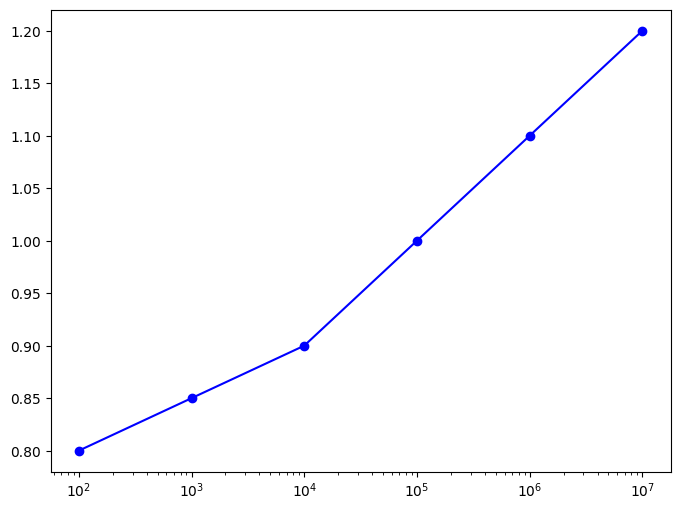

In [7]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

# Example energy bins (6 bins)
energy_bins = np.array([1e2, 1e3, 1e4, 1e5, 1e6, 1e7])  # In GeV

# Example untuned cross-section values (arbitrary for testing)
cs_untuned = np.array([0.8, 0.85, 0.9, 1.0, 1.1, 1.2])

# Define scaling factors: 1.0 everywhere except at e0=1 TeV
scaling_factors = np.ones_like(cs_untuned)
e0_index = np.searchsorted(energy_bins, 1e3)  # Find index for e0=1 TeV
scaling_factors[e0_index] = 1.05  # Apply increase

# Define a smooth transition in the next two bins
interp_energy = energy_bins[max(e0_index-1, 0):e0_index+3]  # Select 3 surrounding bins
interp_scaling = scaling_factors[max(e0_index-1, 0):e0_index+3]

# Create cubic spline interpolation
cs_spline = CubicSpline(interp_energy, interp_scaling, bc_type='natural')

# Interpolate scaling factors at the original energy bins
sf_new = cs_spline(energy_bins)

# Apply the scaling factors to the cross-section data
cs_tuned = cs_untuned * sf_new

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(energy_bins, cs_untuned, 'o-', label="Original CS", color='blue')
plt.plot
plt.xscale('log')


In [8]:
mceq_air.e_grid

NameError: name 'mceq_air' is not defined

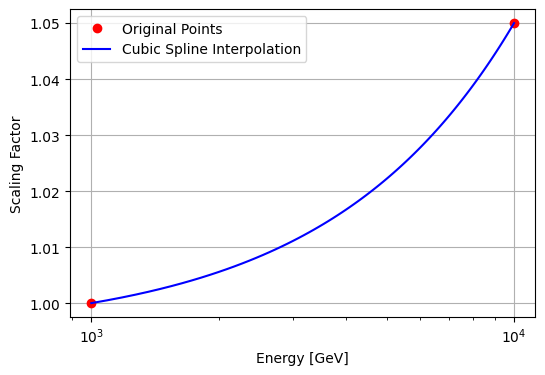

In [ ]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

# Define two points (x1, y1) and (x2, y2)
x = np.array([1e3, 1e4])  # Energy values (GeV)
y = np.array([1.0, 1.05])  # Scaling factors

# Create cubic spline interpolation with 'not-a-knot' boundary conditions
cs = CubicSpline(x, y, bc_type='natural')  

# Generate finer grid for interpolation
x_fine = np.linspace(x[0], x[1], 100)
y_fine = cs(x_fine)

# Plot the results
plt.figure(figsize=(6, 4))
plt.plot(x, y, 'ro', label="Original Points")  # Red dots at original points
plt.plot(x_fine, y_fine, 'b-', label="Cubic Spline Interpolation")
plt.xscale("log")
plt.xlabel("Energy [GeV]")
plt.ylabel("Scaling Factor")
plt.legend()
plt.grid()
plt.show()


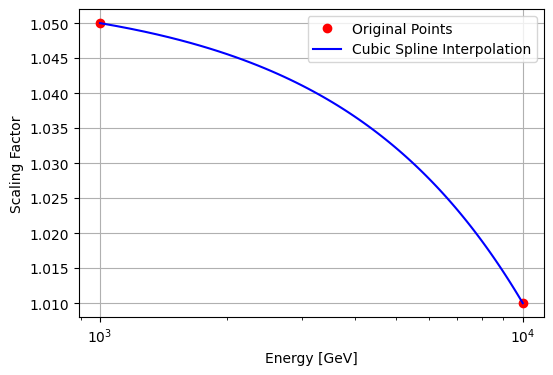

In [ ]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

# Define two points (x1, y1) and (x2, y2)
x = np.array([1e3, 1.e4])  # Energy values (GeV)
y = np.array([1.05, 1.01])  # Scaling factors

# Create cubic spline interpolation with 'not-a-knot' boundary conditions
cs = CubicSpline(x, y, bc_type='natural')  

# Generate finer grid for interpolation
x_fine = np.linspace(x[0], x[1], 100)
y_fine = cs(x_fine)

# Plot the results
plt.figure(figsize=(6, 4))
plt.plot(x, y, 'ro', label="Original Points")  # Red dots at original points
plt.plot(x_fine, y_fine, 'b-', label="Cubic Spline Interpolation")
plt.xscale("log")
plt.xlabel("Energy [GeV]")
plt.ylabel("Scaling Factor")
plt.legend()
plt.grid()
plt.show()


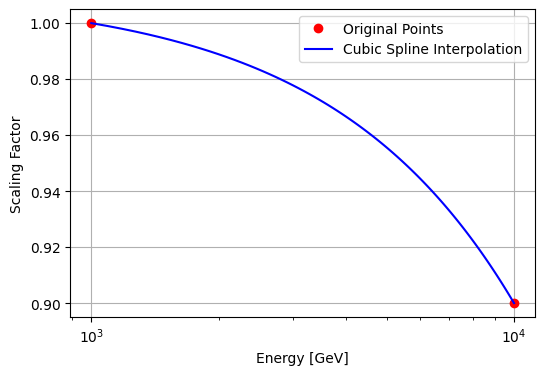

In [ ]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

# Define two points (x1, y1) and (x2, y2)
x = np.array([1e3, 1.e4])  # Energy values (GeV)
y = np.array([1.0, 0.9])  # Scaling factors

# Create cubic spline interpolation with 'not-a-knot' boundary conditions
cs = CubicSpline(x, y, bc_type='natural')  

# Generate finer grid for interpolation
x_fine = np.linspace(x[0], x[1], 100)
y_fine = cs(x_fine)

# Plot the results
plt.figure(figsize=(6, 4))
plt.plot(x, y, 'ro', label="Original Points")  # Red dots at original points
plt.plot(x_fine, y_fine, 'b-', label="Cubic Spline Interpolation")
plt.xscale("log")
plt.xlabel("Energy [GeV]")
plt.ylabel("Scaling Factor")
plt.legend()
plt.grid()
plt.show()

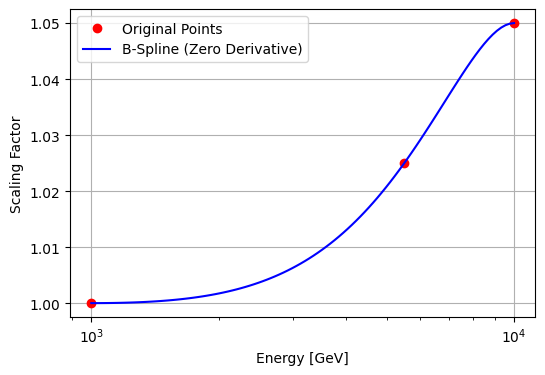

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# Define anchor points (energy and scaling factor)
x1, y1 = 1e3, 1.0    # Energy at E0 (GeV), initial factor
x2, y2 = 1e4, 1.05   # Energy at E1 (GeV), target factor

# Additional points for interpolation (including midpoint)
x_extra = np.array([x1, (x1 + x2) / 2, x2])  # Midpoint added
y_extra = np.array([y1, (y1 + y2) / 2, y2])  # Intermediate scaling factor

# Create B-spline with degree k=3 (cubic)
bspline = make_interp_spline(x_extra, y_extra, k=3, bc_type=([(1, 0.0)], [(1, 0.0)]))

# Generate fine grid for smooth interpolation
x_fine = np.logspace(np.log10(x1), np.log10(x2), 100)
y_fine = bspline(x_fine)

# Plot results
plt.figure(figsize=(6, 4))
plt.plot(x_extra, y_extra, 'ro', label="Original Points")
plt.plot(x_fine, y_fine, 'b-', label="B-Spline (Zero Derivative)")
plt.xscale("log")
plt.xlabel("Energy [GeV]")
plt.ylabel("Scaling Factor")
plt.legend()
plt.grid()
plt.show()

